User
 ->
LLM
 ->
Tool
 ->
LLM

This code:
LLM
 ->
Tool
 ❌ fails
 ->
Retry
 ->
Pause (if needed)
 ->
Human
 ->
Resume


In [43]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_tavily import TavilySearch
from langchain_core.messages import HumanMessage,AIMessage,ToolMessage

In [44]:
tavily = TavilySearch()
tavily.invoke('current date')

{'query': 'current date',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.datetoday.net/',
   'title': "What is the date today? Today's Date",
   'content': 'Today\'s Date is Mon Jan 19 2026. About Date Today. The term "Date Today" refers to the current calendar date as determined by a system\'s internal clock',
   'score': 0.73891455,
   'raw_content': None},
  {'url': 'https://www.rapidtables.com/tools/todays-date.html',
   'title': "Today's Date | Current date now - RapidTables.com",
   'content': "This page includes the following information: Today's date: day of week, month, day, year. Current time: hours, minutes, seconds.",
   'score': 0.64639384,
   'raw_content': None},
  {'url': 'https://isotropic.org/date/',
   'title': "Today's Date - isotropic.org",
   'content': "Today's Date. If this is working, then. Today is: Gregorian: Monday, 19 January 2026. Mayan: Long count = 13.0.13.4.17; tzolkin = 10 Caban; haab = 15 Muan.",
   'sc

In [45]:
arxiv = ArxivQueryRun(api_wrapper=ArxivAPIWrapper(doc_content_chars_max=500))

In [46]:
arxiv.run('imporving camera quality using ai')

'Published: 2025-01-06\nTitle: Foundations of GenIR\nAuthors: Qingyao Ai, Jingtao Zhan, Yiqun Liu\nSummary: The chapter discusses the foundational impact of modern generative AI models on information access (IA) systems. In contrast to traditional AI, the large-scale training and superior data modeling of generative AI models enable them to produce high-quality, human-like responses, which brings brand new opportunities for the development of IA paradigms. In this chapter, we identify and introduce '

In [47]:
wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(doc_content_chars_max=500))

In [48]:
wikipedia.invoke(' pm of india names')

'Page: Prime Minister of India\nSummary: The prime minister of India (ISO: Bhārat kē Pradhānamantrī) is the head of government of the Republic of India. Executive authority is vested in the prime minister and his chosen Council of Ministers, despite the president of India being the nominal head of the executive.  The prime minister has to be a member of one of the houses of bicameral Parliament of India, alongside heading the respective house. The prime minister and the cabinet are at all times re'

In [49]:
import os
from dotenv import load_dotenv

load_dotenv(override=True)

os.environ['GROQ_API_KEY']=os.getenv('GROQ_API_KEY')
os.environ['TAVILY_API_KEY']=os.getenv('TAVILY_API_KEY')
os.environ['LANGSMITH_API_KEY']=os.getenv('LANGSMITH_API_KEY')
os.environ['LANGSMITH_PROJECT']='Agent_React'


In [50]:
# Here docstring is important because llm will read this . so give proper desc.

def multiply(a:int,b:int)->int:
    """
    Multiplies two integers and returns the result.

    Args:
        a (int): The first integer.
        b (int): The second integer.

    Returns:
        int: The product of a and b.
    """
    return a*b


def add(a:int,b:int)->int:
    """
    Adds two integers and returns the result.

    Args:
        a (int): The first integer.
        b (int): The second integer.

    Returns:
        int: The addition of a and b.
    """
    return a+b

def divide(a:int,b:int)->int:
    """
    Divides the first integer by the second and returns the result.

    Args:
        a (int): The numerator.
        b (int): The denominator.

    Returns:
        int: The result of dividing a by b.
    """
    return a/b

In [51]:
tools =[add,multiply,divide,wikipedia,arxiv,tavily]

In [52]:
# Initialize chat model
from langchain_groq import ChatGroq

llm =ChatGroq(model="llama-3.1-8b-instant")

In [53]:
llm_with_tools =llm.bind_tools(tools=tools)

In [54]:
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage
from langgraph.prebuilt import ToolNode,tools_condition
from typing import Annotated,TypedDict
from IPython.display import Image,display


In [55]:
class State(TypedDict):
    messages :Annotated[list[AnyMessage],add_messages]
    retry_count:int #this field is counter for how many times a tool failed (ie) Tracks number of retries for the last failed tool
    approval_status: str  # "pending", "approved", "rejected" ,A human-in-the-loop flag eg :Skip arxiv, continue
    last_failed_tool: str| None #Stores which tool caused the failure ,eg: arxiv(failed) or None (no failure)




In [56]:

# # LLM Node 


# def llm_tool(state: State):
#     """
#     LLM Node:
#     - Runs your LLM and produces output.
#     - Respects pause if human approval is pending.
#     """
#     # Check if agent is paused due to human approval
#     if state.get("approval_status") == "pending":
#         # Agent is paused → return current state, do not run LLM
#         return state

#     # Call your LLM with current conversation messages
#     llm_result = llm_with_tools.invoke(state['messages'])

#     # Prepare result dictionary
#     result = {
#         "messages": [AIMessage(content=llm_result)],  # Store LLM output as message
#         "retry_count": state.get("retry_count", 0),  # Preserve current retry count
#         "last_failed_tool": state.get("last_failed_tool"),  # Preserve last failed tool
#         "approval_status": state.get("approval_status", "approved")  # Preserve approval status
#     }

#     return result


In [57]:
def llm_tool(state: State):
    """
    LLM Node:
    - Runs your LLM and produces output.
    - Respects pause if human approval is pending.
    """
    from langchain_core.messages import AIMessage

    # Pause if human approval is pending
    if state.get("approval_status") == "pending":
        return state

    # Call LLM
    llm_result = llm_with_tools.invoke(state['messages'])

    # Extract plain string content
    if isinstance(llm_result, dict) and "content" in llm_result:
        content_str = llm_result["content"]
    elif isinstance(llm_result, str):
        content_str = llm_result
    else:
        content_str = str(llm_result)  # fallback

    # Return new state
    result = {
        "messages": [AIMessage(content=content_str)],  # now content is guaranteed string
        "retry_count": state.get("retry_count", 0),
        "last_failed_tool": state.get("last_failed_tool"),
        "approval_status": state.get("approval_status", "approved")
    }

    return result


In [58]:

# Safe Tool Node 



from langchain_core.messages import ToolMessage

MAX_RETRIES = 2  # Maximum automatic retries per tool

def safe_tool_node(state: State):
    """
    Tool Node with:
    - Retry logic
    - Pause on too many failures
    - Preserves state
    """
    try:
        # Try to execute all tools
        tool_node = ToolNode(tools)
        result = tool_node.invoke(state)

        # If tools succeed → reset retry/failure info
        result["retry_count"] = 0
        result["last_failed_tool"] = None
        result["approval_status"] = "approved"

        return result

    except Exception as e:
        # Tool failed → increment retry count
        retry = state.get("retry_count", 0) + 1

        if retry > MAX_RETRIES:
            # Too many failures → pause agent for human intervention
            return {
                "messages": [
                    ToolMessage(content=f"Tool failed after {retry} retries: {str(e)}")
                ],
                "retry_count": retry,
                "approval_status": "pending",  # Agent will stop until human approves
                "last_failed_tool": "tools"    # Track which tool caused failure
            }

        # Retry automatically if under MAX_RETRIES
        return {
            "messages": [
                ToolMessage(content=f"Tool failed, retrying ({retry}/{MAX_RETRIES}): {str(e)}")
            ],
            "retry_count": retry,
            "approval_status": "approved",  # Still running automatically
            "last_failed_tool": "tools"     # Track failed tool
        }


In [59]:

# Human Approval Gate Node


def approval_gate(state: State):
    """
    Pause execution if human approval is pending.
    - Raises RuntimeError to stop the graph.
    - Agent can resume later after human approves.
    """
    if state.get("approval_status") == "pending":
        # Stop execution cleanly
        raise RuntimeError("⏸ Waiting for human approval")
    
    # Continue normally if approved
    return state


In [60]:
 #Build the graph


builder = StateGraph(State)

builder.add_node("llm_tool", llm_tool)  # First LLM node
builder.add_node("tools", safe_tool_node)  # Tool node with retry logic
builder.add_node("approval_gate", approval_gate)  # Pause / human-in-loop node

# Graph edges
builder.add_edge(START, "llm_tool")
builder.add_conditional_edges("llm_tool", tools_condition)  # LLM decides if tools needed
builder.add_edge("llm_tool", "tools")  # Run tools after LLM
builder.add_edge("tools", "approval_gate")  # Check if paused
builder.add_edge("approval_gate", "llm_tool")  # Resume final summarization
builder.add_edge("llm_tool", END)  # End node

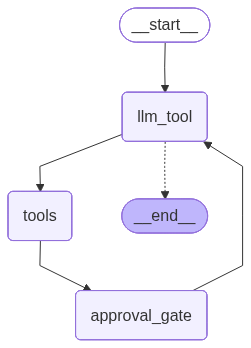

In [61]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
graph_memory = builder.compile(checkpointer=memory)

display(Image(graph_memory.get_graph().draw_mermaid_png()))

In [62]:
# Specify the Config 

config ={"configurable":{"thread_id":"1"}}

In [63]:
import gradio as gr
from langchain.messages import HumanMessage

In [64]:
def chat(query,chat_history):
    # Initialize custom fields for first call
    initial_state = {
        "messages": [HumanMessage(content=query)],
        "retry_count": 0,
        "approval_status": "approved",
        "last_failed_tool": None
    }
    result = graph_memory.invoke(initial_state,config=config)
    print(result)
    return result['messages'][-1].content

what is 5+8 multiplied by 18 and divided by 2

In [65]:
gr.ChatInterface(chat,type='messages').launch()

* Running on local URL:  http://127.0.0.1:7864
* To create a public link, set `share=True` in `launch()`.


Traceback (most recent call last):
  File "c:\Users\Mohamed Arshad\Projects\agents\.venv\Lib\site-packages\gradio\queueing.py", line 625, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Mohamed Arshad\Projects\agents\.venv\Lib\site-packages\gradio\route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Mohamed Arshad\Projects\agents\.venv\Lib\site-packages\gradio\blocks.py", line 2220, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Mohamed Arshad\Projects\agents\.venv\Lib\site-packages\gradio\blocks.py", line 1729, in call_function
    prediction = await fn(*processed_input)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Mohamed Arshad\Projects\agents\.venv\Lib\site-packages\gradio\utils.py", line 871, in async_wrapper